In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/affectnet-dataset/test/surprise/PublicTest_78686873.jpg
/kaggle/input/affectnet-dataset/test/surprise/PrivateTest_58522921.jpg
/kaggle/input/affectnet-dataset/test/surprise/PrivateTest_83796714.jpg
/kaggle/input/affectnet-dataset/test/surprise/PublicTest_84428313.jpg
/kaggle/input/affectnet-dataset/test/surprise/PrivateTest_87978901.jpg
/kaggle/input/affectnet-dataset/test/surprise/PrivateTest_90978621.jpg
/kaggle/input/affectnet-dataset/test/surprise/PrivateTest_27580582.jpg
/kaggle/input/affectnet-dataset/test/surprise/PublicTest_15760011.jpg
/kaggle/input/affectnet-dataset/test/surprise/PublicTest_49739228.jpg
/kaggle/input/affectnet-dataset/test/surprise/PublicTest_5351857.jpg
/kaggle/input/affectnet-dataset/test/surprise/PrivateTest_56096676.jpg
/kaggle/input/affectnet-dataset/test/surprise/PrivateTest_71692098.jpg
/kaggle/input/affectnet-dataset/test/surprise/PublicTest_64532931.jpg
/kaggle/input/affectnet-dataset/test/surprise/PublicTest_17886908.jpg
/kaggle/input/

In [2]:
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import glob
import os
import cv2
import numpy as np

In [3]:

# To Update label extraction function to assign distinct labels for different emotions
def extract_label_from_filename(filename):
    emotion = filename.split('/')[-2]  # Extract the emotion from the path
    # Assigning unique labels based on emotions (adjust labels as needed)
    if emotion == "angry":
        label = 0
    elif emotion == "disgust":
        label = 1
    elif emotion == "fear":
        label = 2
    elif emotion == "happy":
        label = 3
    elif emotion == "neutral":
        label = 4
    elif emotion == "sad":
        label = 5
    elif emotion == "surprise":
        label = 6
    else:
        label = -1  # Unknown label or error handling
    return label

# Function to load images from directory
def load_images_from_directory(directory):
    images = []
    labels = []
    filenames = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            image_path = os.path.join(root, file)
            try:
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, (48, 48))
                    images.append(img)
                    label = extract_label_from_filename(image_path)
                    labels.append(label)
                    filenames.append(image_path)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    return np.array(images), np.array(labels), np.array(filenames)

# Defining directory paths
train_directory = '/kaggle/input/affectnet-dataset/train'
test_directory = '/kaggle/input/affectnet-dataset/test'

# Loads training images and labels
train_images, train_labels, train_filenames = load_images_from_directory(train_directory)

# Loads testing images and labels
test_images, test_labels, test_filenames = load_images_from_directory(test_directory)

# Preprocessing the training images
train_images_preprocessed = train_images / 255.0

# Creating label mapping
unique_labels = np.unique(np.concatenate((train_labels, test_labels)))
label_mapping = {label: index for index, label in enumerate(unique_labels)}

# Converting string labels to integers using the mapping
train_labels_int = np.array([label_mapping[label] for label in train_labels])
test_labels_int = np.array([label_mapping[label] for label in test_labels])

# Save preprocessed data
np.savez_compressed('preprocessed_data.npz', train_images=train_images_preprocessed, train_labels=train_labels_int, train_filenames=train_filenames,
                   test_images=test_images, test_labels=test_labels_int, test_filenames=test_filenames)

# Print information after preprocessing
print("Shape of preprocessed training images:", train_images_preprocessed.shape)
print("Shape of training labels:", train_labels_int.shape)
print("Shape of training filenames:", train_filenames.shape)
print("Shape of preprocessed testing images:", test_images.shape)
print("Shape of testing labels:", test_labels_int.shape)
print("Shape of testing filenames:", test_filenames.shape)


Shape of preprocessed training images: (28709, 48, 48, 3)
Shape of training labels: (28709,)
Shape of training filenames: (28709,)
Shape of preprocessed testing images: (7178, 48, 48, 3)
Shape of testing labels: (7178,)
Shape of testing filenames: (7178,)


In [ ]:
#Define CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Additional convolutional layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
    
# Compiling the model
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Preprocessing the images for training
train_images_preprocessed = train_images / 255.0  # Normalize pixel values to be between 0 and 1

# Train the model
batch_size = 64
epochs = 50

# Training the model
history = model.fit(train_images_preprocessed, train_labels_int, batch_size=batch_size, epochs=epochs, verbose=1 )
print("Training complete.")

# Save the trained model
model.save('emotion_detection_model.h5')
#accuracy was 53.93% at 128,30

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

# Converting labels to integers for training set
train_labels_int = label_encoder.transform(train_labels)

# Convert labels to integers for test set
test_labels_int = label_encoder.transform(test_labels)

In [ ]:
# Assuming you have the 'test_images' variable from previous steps
test_images_preprocessed = test_images / 255.0  # Normalize pixel values to be between 0 and 1

# Assuming the model is already defined and trained
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images_preprocessed, test_labels_int)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
#accuracy was 53.93% at 128,30
#accuracy was 56.78% at 64,50

In [ ]:
#Define CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Additional convolutional layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
    
# Compile the model
from keras.optimizers import Adagrad

optimizer = Adagrad(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Preprocess the images for training
train_images_preprocessed = train_images / 255.0  # Normalize pixel values to be between 0 and 1

# Train the model
batch_size = 64
epochs = 30

# Train the model
history = model.fit(train_images_preprocessed, train_labels_int, batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.2 )
print("Training complete.")

# Save the trained model
model.save('emotion_detection_model.h5')
#accuracy was 51.37%
#Validation Loss: 5.2653
#Validation Accuracy: 48.47%

In [4]:
# Define CNN model with dropout layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Dropout after first convolutional block

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Dropout after second convolutional block

model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Additional convolutional layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Dropout after third convolutional block

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))  # Dropout before the final dense layer

model.add(layers.Dense(7, activation='softmax'))

    
# Compile the model
from keras.optimizers import Adagrad

optimizer = Adagrad(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Preprocess the images for training
train_images_preprocessed = train_images / 255.0  # Normalize pixel values to be between 0 and 1

# Train the model
batch_size = 32
epochs = 30

# Train the model
history = model.fit(train_images_preprocessed, train_labels_int, batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.2 )
print("Training complete.")

# Save the trained model
model.save('emotion_detection_model.h5')

Epoch 1/30
718/718 [==============================] - 45s 61ms/step - loss: 1.8053 - accuracy: 0.2101 - val_loss: 2.6658 - val_accuracy: 0.0000e+00
Epoch 2/30
718/718 [==============================] - 44s 61ms/step - loss: 1.7097 - accuracy: 0.2985 - val_loss: 2.6267 - val_accuracy: 0.0000e+00
Epoch 3/30
718/718 [==============================] - 44s 61ms/step - loss: 1.6562 - accuracy: 0.3274 - val_loss: 2.4201 - val_accuracy: 0.0000e+00
Epoch 4/30
718/718 [==============================] - 44s 61ms/step - loss: 1.6108 - accuracy: 0.3465 - val_loss: 2.5023 - val_accuracy: 0.0037
Epoch 5/30
718/718 [==============================] - 43s 60ms/step - loss: 1.5605 - accuracy: 0.3708 - val_loss: 2.3893 - val_accuracy: 0.0716
Epoch 6/30
718/718 [==============================] - 45s 63ms/step - loss: 1.5131 - accuracy: 0.3983 - val_loss: 2.3879 - val_accuracy: 0.1083
Epoch 7/30
718/718 [==============================] - 44s 61ms/step - loss: 1.4674 - accuracy: 0.4171 - val_loss: 2.0977 - v

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#225/225 [==============================] - 3s 15ms/step - loss: 1.2716 - accuracy: 0.5524
#Test Accuracy: 55.24%

In [ ]:
#Validation Loss: 1.5406
#Validation Accuracy: 54.02%

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

# Converting labels to integers for training set
train_labels_int = label_encoder.transform(train_labels)

# Convert labels to integers for test set
test_labels_int = label_encoder.transform(test_labels)

In [6]:
# Assuming you have the 'test_images' variable from previous steps
test_images_preprocessed = test_images / 255.0  # Normalize pixel values to be between 0 and 1

# Assuming the model is already defined and trained
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images_preprocessed, test_labels_int)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

225/225 [==============================] - 4s 17ms/step - loss: 1.3124 - accuracy: 0.5305
Test Accuracy: 53.05%


225/225 [==============================] - 4s 16ms/step


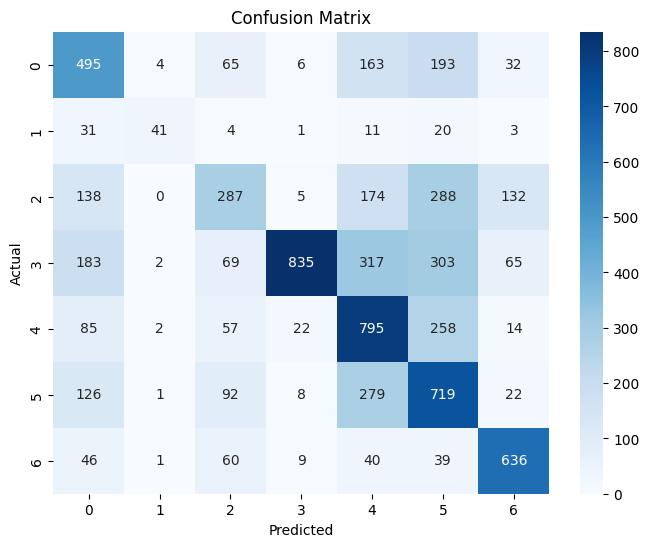

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

test_images_preprocessed = test_images / 255.0  # Normalize pixel values for the test set

# Predicting the labels for the test set
predictions = model.predict(test_images_preprocessed)
predicted_labels = np.argmax(predictions, axis=1)

# Creating a confusion matrix
conf_matrix = confusion_matrix(test_labels_int, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5,6], yticklabels=[0,1,2,3,4,5,6])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


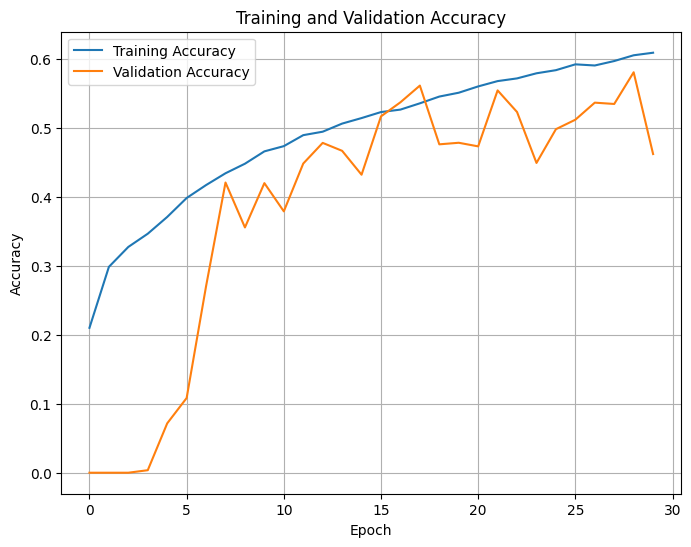

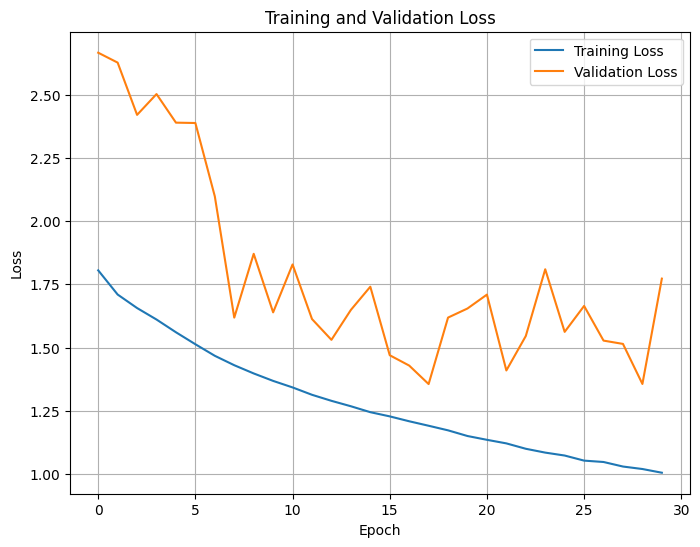

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# for Printing schematic plot of the model
plot_model(model, to_file='model_schematic.png', show_shapes=True, show_layer_names=True)

# Retrieve training and validation accuracy and loss values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
